## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "german_age"
BASELINE = "mlp" 
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 2
ATTACK = "mia2"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
DATASET

'german_age'

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

Inside load_data(), self.DATASET = german_age


In [11]:
dataset_orig.label_names

['credit']

In [12]:
df, _ = dataset_orig.convert_to_dataframe()
df[['age', 'credit']].value_counts()

age  credit
1.0  1.0       590
     0.0       220
0.0  1.0       110
     0.0        80
Name: count, dtype: int64

In [13]:
dataset_orig.features.shape

(1000, 57)

In [14]:
privileged_groups

[{'age': 1}]

In [15]:
sens_attr

'age'

In [16]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [17]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [18]:
seed = 1234
np.random.seed(seed)

In [19]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [20]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [21]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [22]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [23]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [24]:
df, _ = dataset_orig.convert_to_dataframe()

In [25]:
# target_dataset = None
# reference_dataset = None

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [28]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(DATASET, dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
GET UNIQUE INDICES REFERENCE
Number of train points: 120
Number of test points: 120
Number of population points: 300
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  97.0 23.0
base_pos unpriv:  0.43478260869565216
base_pos priv:  0.7010309278350515
DIFFERENCE IS GOOD
base_pos unpriv:  0.43478260869565216
base_pos priv:  0.7010309278350515
no bias type specified
#### Training Dataset shape
(120, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_histor

Best thresh:  [0.44109925]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: [0.86545347]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 13, Test = 12
  AUC: 0.18
  Privacy Risk: 0.50
  Accuracy: 0.48
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.60
  Positive predictive value: 0.52
  Optimal thershold: [0.47040595]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 10, Test = 13
  AUC: 0.37
  Privacy Risk: 0.50
  Accuracy: 0.57
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.38
  Positive predictive value: 0.43
  Optimal thershold: [0.79601366]
)
MIA_Result(
  Name: subpopulation_1.0_label_

Best thresh:  [0.46398478]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.46
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.12
  Positive predictive value: 1.00
  Optimal thershold: [0.51510747]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 7, Test = 10
  AUC: 0.39
  Privacy Risk: 0.76
  Accuracy: 0.76
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.51
  Positive predictive value: 0.71
  Optimal thershold: [0.53002824]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 10, Test = 16
  AUC: 0.37
  Privacy Risk: 0.50
  Accuracy: 0.62
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.38
  Positive predictive value: 0.43
  Optimal thershold: [0.9206786]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

Best thresh:  [0.46267362]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.13
  Test Accuracy (TNR): 0.94
  Attacker advantage: 0.07
  Positive predictive value: 1.00
  Optimal thershold: [0.50608199]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 7, Test = 10
  AUC: 0.39
  Privacy Risk: 0.69
  Accuracy: 0.71
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.41
  Positive predictive value: 0.67
  Optimal thershold: [0.53286075]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 10, Test = 16
  AUC: 0.39
  Privacy Risk: 0.50
  Accuracy: 0.62
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.38
  Positive predictive value: 0.42
  Optimal thershold: [0.90284594]
)
MIA_Result(
  Name: subpopulation_1.0_label_0

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Checking predict proba
Best thresh:  [0.45989891]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.05
  Positive predictive value: 0.75
  Optimal thershold: [0.5144344]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 7
  AUC: 0.34
  Privacy Risk: 0.45
  Accuracy: 0.53
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.37
  Positive predictive value: 1.00
  Optimal thershold: [0.47456803]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 18, Test = 12
  AUC: 0.46
  Privacy Risk: 0.50
  Accuracy: 0.60
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.14
  Positive

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.173607       0.184522                         0.268301   
1    0.078050       0.013857                         0.265369   
2    0.064544       0.029961                         0.274312   
3    0.007983       0.035799                         0.090475   
4    0.101630       0.023649                         0.265802   
..        ...            ...                              ...   
115  0.032612       0.002425                         0.184801   
116  0.180751       0.149247                         0.000000   
117  0.032068       0.007739                         0.272579   
118  0.083424       0.098605                         0.094548   
119  0.081127       0.065884                         0.091944   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.000000  1.0           0.000000           0.000000    0.000000   
1           0.265369  1.0     

Best thresh:  [0.45915412]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.52
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.08
  Positive predictive value: 0.57
  Optimal thershold: [0.89812656]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 7
  AUC: 0.36
  Privacy Risk: 0.45
  Accuracy: 0.53
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.36
  Positive predictive value: 1.00
  Optimal thershold: [0.47627242]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 18, Test = 12
  AUC: 0.44
  Privacy Risk: 0.50
  Accuracy: 0.60
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.17
  Positive predictive value: 0.75
  Optimal thershold: [0.8240942]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.40158781]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.06
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.06
  Positive predictive value: 0.58
  Optimal thershold: [0.49106129]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 9, Test = 11
  AUC: 0.10
  Privacy Risk: 0.50
  Accuracy: 0.45
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.71
  Positive predictive value: 0.45
  Optimal thershold: [0.62773812]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 17, Test = 13
  AUC: 0.49
  Privacy Risk: 0.60
  Accuracy: 0.63
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.21
  Positive predictive value: 1.00
  Optimal th

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.084066       0.067558                         0.248542   
1    0.104890       0.048166                         0.091442   
2    0.123525       0.111646                         0.262491   
3    0.016039       0.014808                         0.181775   
4    0.031908       0.042890                         0.000000   
..        ...            ...                              ...   
295  0.032322       0.030869                         0.274735   
296  0.032462       0.026994                         0.275926   
297  0.081266       0.030482                         0.276303   
298  0.032538       0.067340                         0.000000   
299  0.008450       0.017420                         0.000000   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.248542  1.0           0.248542           0.248542    0.000000   
1           0.274327  0.0     

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Checking predict proba
Testing EG ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.06
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: [0.4904763]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 9, Test = 11
  AUC: 0.11
  Privacy Risk: 0.50
  Accuracy: 0.45
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.71
  Positive predictive value: 0.45
  Optimal thershold: [0.62655967]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 17, Test = 13
  AUC: 0.49
  Privacy Risk: 0.60
  Accuracy: 0.63
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.19
  Positive predictive value

TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.065585       0.179425                         0.262339   
1    0.127518       0.113391                         0.270976   
2    0.124730       0.030233                         0.265051   
3    0.027390       0.016734                         0.266070   
4    0.007829       0.006591                         0.266193   
..        ...            ...                              ...   
295  0.213860       0.100694                         0.259687   
296  0.056763       0.012212                         0.275706   
297  0.020049       0.003121                         0.272671   
298  0.101088       0.058626                         0.264383   
299  0.080287       0.091082                         0.272975   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.262339  1.0           0.000000                0.0    0.000000  

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Checking predict proba
Testing EG ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.09
  Positive predictive value: 0.60
  Optimal thershold: [0.91018957]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 10
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.16
  Positive predictive value: 0.67
  Optimal thershold: [0.52063465]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 20, Test = 12
  AUC: 0.52
  Privacy Risk: 0.56
  Accuracy: 0.66
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.12
  Positive predictive val

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.054519       0.086753                         0.088269   
1    0.070262       0.057620                         0.093683   
2    0.058504       0.026237                         0.094720   
3    0.024890       0.018129                         0.188055   
4    0.032612       0.001357                         0.277202   
..        ...            ...                              ...   
115  0.082749       0.130007                         0.093782   
116  0.008122       0.009269                         0.000000   
117  0.044813       0.018200                         0.277025   
118  0.032472       0.009659                         0.276014   
119  0.146922       0.054857                         0.262913   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.264806  1.0           0.000000           0.264806    0.000000   
1           0.187366  1.0     

Best thresh:  [0.42816366]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.49
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.56379772]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 13
  AUC: 0.40
  Privacy Risk: 0.52
  Accuracy: 0.54
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.27
  Positive predictive value: 0.50
  Optimal thershold: [0.56169315]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 13, Test = 17
  AUC: 0.43
  Privacy Risk: 0.50
  Accuracy: 0.57
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.16
  Positive predictive value: 0.50
  Optimal thershold: [0.94356265]
)
MIA_Result(
  Name: subpopulation_1.0_label_

Best thresh:  [0.45436002]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.44
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.01
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.13
  Positive predictive value: 1.00
  Optimal thershold: [0.46017155]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 6, Test = 11
  AUC: 0.36
  Privacy Risk: 0.45
  Accuracy: 0.59
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.36
  Positive predictive value: 0.33
  Optimal thershold: [0.53986737]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 14, Test = 13
  AUC: 0.51
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.25
  Positive predictive value: 0.62
  Optimal thershold: [0.90670506]
)
MIA_Result(
  Name: subpopulation_1.0_label_0

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.024774       0.029075                         0.093590   
1    0.082640       0.043938                         0.187318   
2    0.031409       0.034213                         0.266973   
3    0.044581       0.046903                         0.275594   
4    0.071917       0.042310                         0.000000   
..        ...            ...                              ...   
295  0.030362       0.006660                         0.258074   
296  0.056258       0.097895                         0.091084   
297  0.024426       0.056343                         0.000000   
298  0.080347       0.082567                         0.091059   
299  0.132574       0.111330                         0.093907   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.187180  1.0           0.093590           0.000000    0.280771   
1           0.093659  0.0     

RUN MIA2 ATTACK
Results are stored in: ['eg_log_group']
Results are stored in: ['eg_log_pop']
TEST
Checking predict proba
Testing EG ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.45
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.01
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.13
  Positive predictive value: 1.00
  Optimal thershold: [0.4601641]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 6, Test = 11
  AUC: 0.36
  Privacy Risk: 0.45
  Accuracy: 0.59
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.36
  Positive predictive value: 0.33
  Optimal thershold: [0.53989539]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 14, Test = 13
  AUC: 0.51
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.25
  Positive predictive value

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.032473       0.007989                         0.276018   
1    0.133209       0.053907                         0.094357   
2    0.007860       0.001735                         0.267253   
3    0.069082       0.050920                         0.000000   
4    0.008375       0.000000                         0.094912   
..        ...            ...                              ...   
115  0.080853       0.051580                         0.091633   
116  0.045499       0.068204                         0.187511   
117  0.080951       0.015129                         0.275234   
118  0.075417       0.027470                         0.256418   
119  0.057985       0.026515                         0.187761   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.092006  1.0           0.000000           0.000000    0.000000   
1           0.094357  1.0     

Best thresh:  [0.45257509]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.11
  Positive predictive value: 1.00
  Optimal thershold: [0.53050065]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 9, Test = 6
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.60
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.17
  Positive predictive value: 1.00
  Optimal thershold: [0.53497895]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 14, Test = 11
  AUC: 0.37
  Privacy Risk: 0.50
  Accuracy: 0.56
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.29
  Positive predictive value: 0.67
  Optimal thershold: [0.82462422]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.45134458]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.53
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.12
  Positive predictive value: 1.00
  Optimal thershold: [0.86828598]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 18, Test = 11
  AUC: 0.42
  Privacy Risk: 0.50
  Accuracy: 0.62
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.27
  Positive predictive value: 1.00
  Optimal thershold: [0.5447715]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 18, Test = 12
  AUC: 0.67
  Privacy Risk: 0.75
  Accuracy: 0.73
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.83
  Attacker advan

Best thresh:  [0.45084927]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.53
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.14
  Positive predictive value: 0.67
  Optimal thershold: [0.90911821]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 18, Test = 11
  AUC: 0.43
  Privacy Risk: 0.50
  Accuracy: 0.62
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.27
  Positive predictive value: 1.00
  Optimal thershold: [0.5511696]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 18, Test = 12
  AUC: 0.68
  Privacy Risk: 0.75
  Accuracy: 0.73
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.50
  Positive predictive value: 1.00
  Optimal thershold: [0.87040271]
)
MIA_Result(
  Name: subpopulation_1.0_label_0

RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.44881508]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.09
  Positive predictive value: 1.00
  Optimal thershold: [0.84051152]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 6
  AUC: 0.43
  Privacy Risk: 0.50
  Accuracy: 0.62
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.23
  Positive predictive value: 0.75
  Optimal thershold: [0.50440648]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 11, Test = 11
  AUC: 0.47
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.55
  Attacker advan

This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.44613104]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.84741022]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 6
  AUC: 0.46
  Privacy Risk: 0.50
  Accuracy: 0.62
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.20
  Positive predictive value: 0.75
  Optimal thershold: [0.51894743]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 11, Test = 11
  AUC: 0.47
  Privacy Risk: 0.64
  A

origin, transf:  120 178
after transf priv:  0.7415730337078652
after transf unpriv:  0.7415730337078652
Difference in mean outcomes between unprivileged and privileged groups = 0.000000
This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.44912928]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.44
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.12
  Positive predictive value: 0.50
  Optimal thershold: [0.44382603]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 8, Test = 13
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.67
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.26
  Positive

Best thresh:  [0.4484935]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.45
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.12
  Positive predictive value: 0.50
  Optimal thershold: [0.91769549]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 8, Test = 13
  AUC: 0.62
  Privacy Risk: 0.56
  Accuracy: 0.67
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.26
  Positive predictive value: 1.00
  Optimal thershold: [0.54700376]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 23, Test = 12
  AUC: 0.48
  Privacy Risk: 0.52
  Accuracy: 0.63
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.15
  Positive predictive value: 1.00
  Optimal thershold: [0.90653868]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Checking predict proba
Best thresh:  [0.46251346]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.52
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.29
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.13
  Positive predictive value: 1.00
  Optimal thershold: [0.54054412]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 10
  AUC: 0.69
  Privacy Risk: 0.75
  Accuracy: 0.75
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.50
  Positive predictive value: 0.67
  Optimal thershold: [0.53661383]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 15, Test = 12
  AUC: 0.56
  Privacy Risk: 0.59
  Accuracy: 0.63
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.25
  Attacker advantag

Best thresh:  [0.4616433]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.54
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.82
  Attacker advantage: 0.12
  Positive predictive value: 1.00
  Optimal thershold: [0.54097412]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 10
  AUC: 0.69
  Privacy Risk: 0.75
  Accuracy: 0.75
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.50
  Positive predictive value: 0.67
  Optimal thershold: [0.5350204]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 15, Test = 12
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.59
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.20
  Positive predictive value: 1.00
  Optimal thershold: [0.83476211]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Checking predict proba
Best thresh:  [0.46559234]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.07
  Positive predictive value: 0.83
  Optimal thershold: [0.85825995]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 12
  AUC: 0.61
  Privacy Risk: 0.68
  Accuracy: 0.70
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.42
  Positive predictive value: 1.00
  Optimal thershold: [0.58181679]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 9, Test = 14
  AUC: 0.36
  Privacy Risk: 0.56
  Accuracy: 0.65
  Train Accuracy (TPR): 0.11
  Test Accuracy (TNR): 1.00
  Attacker advantage

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.054710       0.023935                         0.265732   
1    0.084220       0.030032                         0.248999   
2    0.169506       0.053751                         0.261964   
3    0.078045       0.017404                         0.265355   
4    0.055827       0.013712                         0.271158   
..        ...            ...                              ...   
115  0.132684       0.139953                         0.093985   
116  0.080872       0.046826                         0.274964   
117  0.020300       0.017287                         0.276074   
118  0.084141       0.041651                         0.095360   
119  0.044414       0.035970                         0.091520   

     residence_since  age  number_of_credits  people_liable_for  status=A11  \
0           0.265732  1.0           0.088577           0.000000    0.000000   
1           0.248999  1.0     

Best thresh:  [0.46607186]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.49
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.10
  Test Accuracy (TNR): 0.94
  Attacker advantage: 0.07
  Positive predictive value: 1.00
  Optimal thershold: [0.50283613]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 12
  AUC: 0.57
  Privacy Risk: 0.68
  Accuracy: 0.70
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.42
  Positive predictive value: 1.00
  Optimal thershold: [0.5811219]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 9, Test = 14
  AUC: 0.37
  Privacy Risk: 0.56
  Accuracy: 0.65
  Train Accuracy (TPR): 0.11
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.34
  Positive predictive value: 1.00
  Optimal thershold: [0.81335387]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

origin, transf:  120 130
after transf priv:  0.74
after transf unpriv:  0.7333333333333333
Difference in mean outcomes between unprivileged and privileged groups = -0.006667
This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.45531448]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.10
  Positive predictive value: 0.50
  Optimal thershold: [0.87774779]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 8, Test = 8
  AUC: 0.38
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.38
  Positive predictive va

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.45943444]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.87685072]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 8, Test = 8
  AUC: 0.36
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.38
  Positive predictive value: 0.50
  Optimal thershold: [0.47574859]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 12, Test = 14
  AUC: 0.46
  Privacy Risk: 0.50
  Accuracy: 0.54
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantag

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Checking predict proba
Best thresh:  [0.40245456]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.89502814]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 14, Test = 9
  AUC: 0.63
  Privacy Risk: 0.71
  Accuracy: 0.70
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.42
  Positive predictive value: 1.00
  Optimal thershold: [0.54003732]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 11, Test = 15
  AUC: 0.14
  Privacy Risk: 0.50
  Accuracy: 0.58
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage

This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.39893739]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.52
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.85
  Attacker advantage: 0.08
  Positive predictive value: 0.67
  Optimal thershold: [0.5375094]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 14, Test = 9
  AUC: 0.64
  Privacy Risk: 0.71
  Accuracy: 0.70
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.42
  Positive predictive value: 1.00
  Optimal thershold: [0.53759839]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 11, Test = 15
  AUC: 0.12
  Privacy Risk: 0.50
  Ac

origin, transf:  120 136
after transf priv:  0.75
after transf unpriv:  0.75
Difference in mean outcomes between unprivileged and privileged groups = 0.000000
This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.46175441]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.49
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.85
  Attacker advantage: 0.07
  Positive predictive value: 0.60
  Optimal thershold: [0.53809336]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 10
  AUC: 0.62
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.40
  Positive predictive value: 0.67
  O

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.45960814]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.26
  Test Accuracy (TNR): 0.82
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.54089982]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 10
  AUC: 0.60
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.30
  Positive predictive value: 0.67
  Optimal thershold: [0.54030352]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 14, Test = 14
  AUC: 0.43
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.36
  Attacker advant

Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.46679645]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.49
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.52162241]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 10
  AUC: 0.38
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.30
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.20
  Positive predictive value: 1.00
  Optimal thershold: [0.56400393]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 12, Test = 10
  AUC: 0.44
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.13
  Po

Best thresh:  [0.4638357]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.53186078]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 10, Test = 10
  AUC: 0.36
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.20
  Positive predictive value: 1.00
  Optimal thershold: [0.56366433]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 12, Test = 10
  AUC: 0.44
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.13
  Positive predictive value: 0.62
  Optimal thershold: [0.84931133]
)
MIA_Result(
  Name: subpopulation_1.0_label_0

origin, transf:  120 121
after transf priv:  0.6701030927835051
after transf unpriv:  0.6666666666666666
Difference in mean outcomes between unprivileged and privileged groups = -0.003436
This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.45846351]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.92676765]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 8, Test = 12
  AUC: 0.42
  Privacy Risk: 0.50
  Accuracy: 0.60
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.33
  Positiv

Best thresh:  [0.45989705]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.65953324]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 8, Test = 12
  AUC: 0.41
  Privacy Risk: 0.46
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 0.92
  Attacker advantage: 0.33
  Positive predictive value: 0.42
  Optimal thershold: [0.52655599]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 15, Test = 12
  AUC: 0.21
  Privacy Risk: 0.64
  Accuracy: 0.67
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.28
  Positive predictive value: 1.00
  Optimal thershold: [0.92021836]
)
MIA_Result(
  Name: subpopulation_1.0_label_0

origin, transf:  120 153
after transf priv:  0.8041237113402062
after transf unpriv:  0.8035714285714286
Difference in mean outcomes between unprivileged and privileged groups = -0.000552
This is how I see model type:  mlp
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.44884418]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.07
  Positive predictive value: 0.67
  Optimal thershold: [0.89406836]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 9
  AUC: 0.52
  Privacy Risk: 0.67
  Accuracy: 0.65
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.34
  Positiv

Best thresh:  [0.44601939]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.49
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.09
  Positive predictive value: 0.52
  Optimal thershold: [0.86038506]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 9
  AUC: 0.52
  Privacy Risk: 0.67
  Accuracy: 0.65
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.34
  Positive predictive value: 1.00
  Optimal thershold: [0.50135569]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 12, Test = 4
  AUC: 0.70
  Privacy Risk: 0.71
  Accuracy: 0.81
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.42
  Positive predictive value: 1.00
  Optimal thershold: [0.90790206]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Checking predict proba
Best thresh:  [0.46235138]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: [0.84505072]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 9
  AUC: 0.28
  Privacy Risk: 0.56
  Accuracy: 0.60
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.28
  Positive predictive value: 0.58
  Optimal thershold: [0.57856002]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 16, Test = 15
  AUC: 0.51
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.12
  Positiv

Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.46118509]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.82969642]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 11, Test = 9
  AUC: 0.25
  Privacy Risk: 0.56
  Accuracy: 0.60
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.30
  Positive predictive value: 0.58
  Optimal thershold: [0.57817683]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 16, Test = 15
  AUC: 0.49
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.12
  Positive predictive value: 0.75
  Optimal ther

## Feature Analysis

In [29]:
# # Dictionary to store SHAP values
# shap_results = {
#     "orig": orig_metrics['shap_values'],
#     "transf": transf_metrics['shap_values'],
#     "dir": dir_metrics['shap_values'],
#     "reweigh": reweigh_metrics['shap_values'],
#     "eg": eg_metrics['shap_values']
# }

In [30]:
# shap_results = pd.DataFrame.from_dict(shap_results)

In [31]:
# # File path
# today = datetime.now().strftime('%Y-%m-%d')
# file_path = f"./mia2_results/rf_{ATTACK}_{DATASET}_shap_values_{today}.csv"

# # Save to CSV
# shap_results.to_csv(file_path, index=True)

# file_path

## Display Output

In [32]:
priv_metric_orig_copy = priv_metric_orig

In [33]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 1911.0, 'total_unpriv': 489.0})

In [34]:
priv_metric_orig

defaultdict(float, {'total_priv': 1911.0, 'total_unpriv': 489.0})

In [35]:
priv_metric_orig.items()

dict_items([('total_priv', 1911.0), ('total_unpriv', 489.0)])

In [36]:
priv_metric_orig = priv_metric_orig_copy

In [37]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

german_age
120
2)

              total_priv  total_unpriv
num_instance                          
orig               95.55         24.45
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.706250       0.293750    0.738345      0.261655      0.578314   
transf      0.737528       0.262472    0.738345      0.261655      0.735371   

         unpriv_unfavor  
dataset                  
orig           0.421686  
transf         0.264629  


# Train/Test Accuracies

In [38]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [39]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [40]:
def calculate_mean_std_accuracy(acc_metrics):
    mean_std_accuracies = {
        key: {
            "mean": sum(values) / len(values),
            "std": statistics.stdev(values) if len(values) > 1 else 0  # Avoid error if only one value
        }
        for key, values in acc_metrics.items()
    }
    return mean_std_accuracies

In [41]:
orig_acc_stats = calculate_mean_std_accuracy(orig_acc)
transf_acc_stats = calculate_mean_std_accuracy(transf_acc)
reweigh_acc_stats = calculate_mean_std_accuracy(reweigh_acc)
dir_acc_stats = calculate_mean_std_accuracy(dir_acc)
eg_acc_stats = calculate_mean_std_accuracy(eg_acc)

In [42]:
# Convert dictionary to DataFrame with mean and std
train_test_data = {
    "orig_acc_mean": {key: value["mean"] for key, value in orig_acc_stats.items()},
    "orig_acc_std": {key: value["std"] for key, value in orig_acc_stats.items()},
    "transf_acc_mean": {key: value["mean"] for key, value in transf_acc_stats.items()},
    "transf_acc_std": {key: value["std"] for key, value in transf_acc_stats.items()},
    "reweigh_acc_mean": {key: value["mean"] for key, value in reweigh_acc_stats.items()},
    "reweigh_acc_std": {key: value["std"] for key, value in reweigh_acc_stats.items()},
    "dir_acc_mean": {key: value["mean"] for key, value in dir_acc_stats.items()},
    "dir_acc_std": {key: value["std"] for key, value in dir_acc_stats.items()},
    "eg_acc_mean": {key: value["mean"] for key, value in eg_acc_stats.items()},
    "eg_acc_std": {key: value["std"] for key, value in eg_acc_stats.items()},
}

## Save Data

In [43]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./nn_mia2_results/{BASELINE}_{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./nn_mia2_results/mlp_mia2_german_age_train_test_accuracies_2025-04-03.csv'

In [44]:
train_test_df

,orig_acc_mean,orig_acc_std,transf_acc_mean,transf_acc_std,reweigh_acc_mean,reweigh_acc_std,dir_acc_mean,dir_acc_std,eg_acc_mean,eg_acc_std
accuracy_train_0_-,1.00000,0.000000,0.975000,0.111803,1.00000,0.000000,1.00000,0.000000,0.993750,0.027951
accuracy_train_0_+,0.00000,0.000000,0.038333,0.171432,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
accuracy_train_1_-,1.00000,0.000000,0.980435,0.087498,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000
accuracy_train_1_+,0.00000,0.000000,0.030435,0.136108,0.00000,0.000000,0.00000,0.000000,0.001494,0.004600
accuracy_test_0_-,1.00000,0.000000,0.978571,0.095831,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000
accuracy_test_0_+,0.00000,0.000000,0.029167,0.130437,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
accuracy_test_1_-,1.00000,0.000000,0.967308,0.146204,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000
accuracy_test_1_+,0.00000,0.000000,0.029333,0.131183,0.00000,0.000000,0.00000,0.000000,0.001342,0.004132
accuracy_train,0.29375,0.037646,0.281790,0.092858,0.29375,0.037646,0.29375,0.037646,0.295000,0.037794
accuracy_test,0.30250,0.041719,0.315417,0.065799,0.30250,0.041719,0.30250,0.041719,0.302917,0.041471


In [45]:
train_test_df.head()

,orig_acc_mean,orig_acc_std,transf_acc_mean,transf_acc_std,reweigh_acc_mean,reweigh_acc_std,dir_acc_mean,dir_acc_std,eg_acc_mean,eg_acc_std
accuracy_train_0_-,1.0,0.0,0.975000,0.111803,1.0,0.0,1.0,0.0,0.993750,0.027951
accuracy_train_0_+,0.0,0.0,0.038333,0.171432,0.0,0.0,0.0,0.0,0.000000,0.000000
accuracy_train_1_-,1.0,0.0,0.980435,0.087498,1.0,0.0,1.0,0.0,1.000000,0.000000
accuracy_train_1_+,0.0,0.0,0.030435,0.136108,0.0,0.0,0.0,0.0,0.001494,0.004600
accuracy_test_0_-,1.0,0.0,0.978571,0.095831,1.0,0.0,1.0,0.0,1.000000,0.000000


In [46]:
# feature_importance_df = pd.DataFrame(orig_metrics["feature_importances"])  # Extract feature importance across runs
# feature_importance_df

In [47]:
orig_metrics

defaultdict(list,
            {'bal_acc': [0.5,
              0.5,
              0.5,
              0.6036931818181819,
              0.5,
              0.5605335157318742,
              0.5,
              0.5178947368421053,
              0.5,
              0.5,
              0.5068493150684932,
              0.5,
              0.5,
              0.5,
              0.5439666238767651,
              0.5060240963855421,
              0.5,
              0.5,
              0.5,
              0.5],
             'disp_imp': [0,
              1,
              0.5,
              0.246376811594203,
              0.5634057971014492,
              0.08064516129032262,
              0.6015953716690041,
              0.08588498879761008,
              0.6152614836934264,
              0.5896478206504427,
              0.5717182565203542,
              0.5586785735166535,
              0.548898811263878,
              0.5413759172232813,
              0.21250000000000013,
              1.0,
       

In [48]:
# del orig_metrics['shap_values']
# del transf_metrics['shap_values']
# del reweigh_metrics['shap_values']
# del dir_metrics['shap_values']
# del eg_metrics['shap_values']

In [49]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

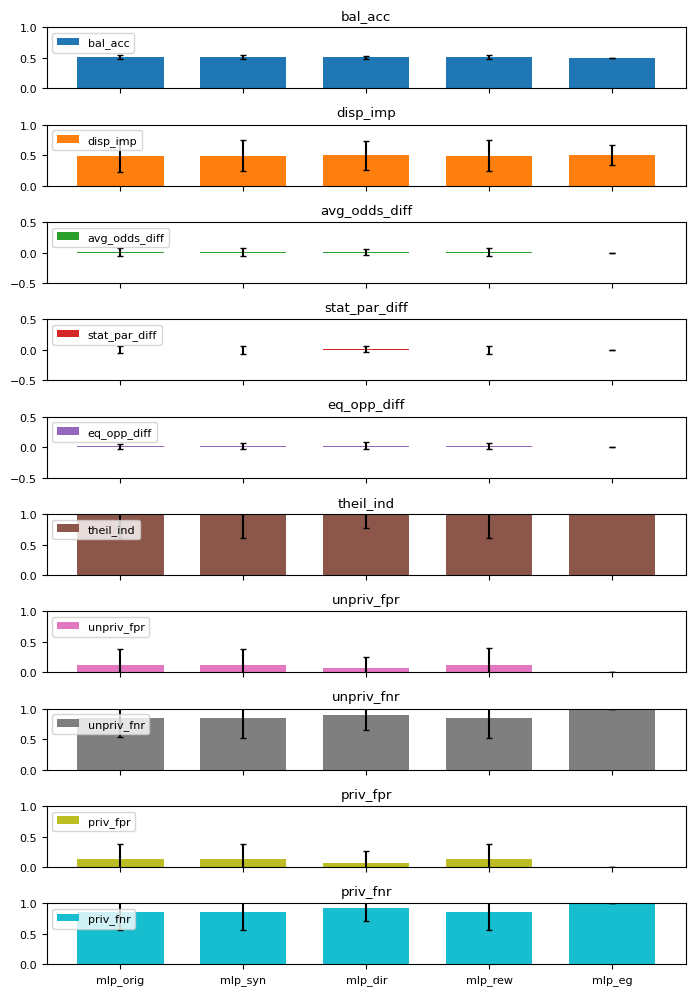

In [50]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [51]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./nn_mia2_results/{BASELINE}_{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./nn_mia2_results/mlp_mia2_german_age_fairness_metrics_2025-04-03.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [52]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [53]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           orig_mia_error_metrics,
           transf_mia_metrics_mean,
           transf_mia_error_metrics,
           dir_mia_metrics_mean,
           dir_mia_error_metrics,
           reweigh_mia_metrics_mean,
           reweigh_mia_error_metrics,
           eg_mia_metrics_mean,
           eg_mia_error_metrics
          ]

index = pd.Series(['orig'] + ['orig_std'] + ['syn'] + ['syn_std'] + ['dir'] + ['dir_std'] + ['rew'] + 
                  ['rew_std'] + ['eg'] + ['eg_std'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,
orig,0.529375,0.578986,0.568878,0.564680,0.534452
orig_std,0.019236,0.099011,0.073082,0.051475,0.034124
syn,0.531250,0.581486,0.576517,0.563932,0.536597
syn_std,0.020165,0.096174,0.073487,0.049216,0.033824
dir,0.530833,0.564518,0.563205,0.578321,0.536942
dir_std,0.020917,0.100817,0.072539,0.063547,0.038931
rew,0.529375,0.578986,0.570664,0.564079,0.534071
rew_std,0.018997,0.099011,0.072664,0.052762,0.033740
eg,0.529167,0.578986,0.568878,0.565185,0.533910


In [54]:
results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean,
          ]

errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

In [55]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [56]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [57]:
df_groups = df_groups.rename(columns={'subpopulation_0.0_label_0.0_mia_privacy_risk': 'G0-',
                           'subpopulation_1.0_label_0.0_mia_privacy_risk': 'G1-',
                           'subpopulation_0.0_label_1.0_mia_privacy_risk': 'G0+',
                           'subpopulation_1.0_label_1.0_mia_privacy_risk': 'G1+'})

In [58]:
df_groups

,G0-,G1-,G0+,G1+
Classifier MIA Attacks,,,,
orig,0.578986,0.564680,0.568878,0.534452
orig_std,0.099011,0.051475,0.073082,0.034124
syn,0.581486,0.563932,0.576517,0.536597
syn_std,0.096174,0.049216,0.073487,0.033824
dir,0.564518,0.578321,0.563205,0.536942
dir_std,0.100817,0.063547,0.072539,0.038931
rew,0.578986,0.564079,0.570664,0.534071
rew_std,0.099011,0.052762,0.072664,0.033740
eg,0.578986,0.565185,0.568878,0.533910


<Axes: xlabel='Classifier MIA Attacks'>

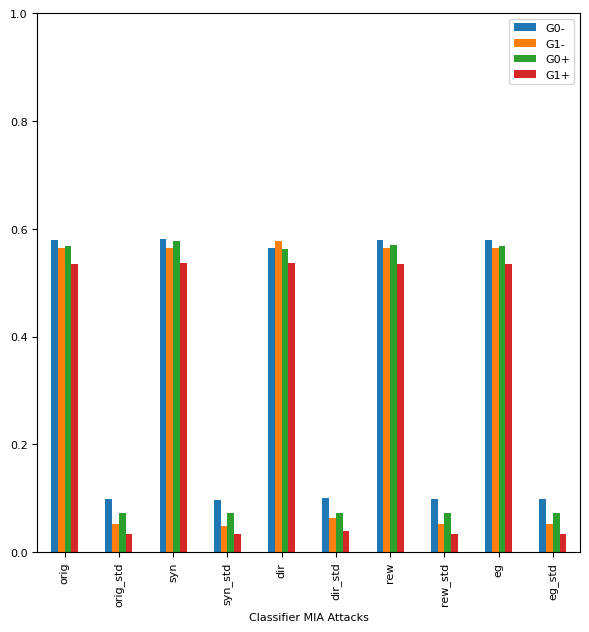

In [59]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [60]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

         orig    orig_std       syn    syn_std       dir    dir_std       rew    rew_std        eg     eg_std
---  --------  ----------  --------  ---------  --------  ---------  --------  ---------  --------  ---------
G0-  0.578986   0.0990112  0.581486  0.0961735  0.564518  0.100817   0.578986  0.0990112  0.578986  0.0990112
G1-  0.56468    0.0514751  0.563932  0.0492157  0.578321  0.063547   0.564079  0.0527616  0.565185  0.0519079
G0+  0.568878   0.0730816  0.576517  0.0734866  0.563205  0.072539   0.570664  0.0726637  0.568878  0.0730816
G1+  0.534452   0.0341236  0.536597  0.0338239  0.536942  0.0389311  0.534071  0.0337398  0.53391   0.0336713


## Save Results

In [61]:
errors

[{'entire_dataset_mia_privacy_risk': 0.019235906589999383,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.09901121187204573,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.07308155275584019,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.05147507678825197,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.03412360906166623},
 {'entire_dataset_mia_privacy_risk': 0.02016470919889558,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.09617351242878823,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.07348657570305332,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.049215690141234655,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.03382387355828778},
 {'entire_dataset_mia_privacy_risk': 0.02091650066335189,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.10081697414347086,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.07253898432697473,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.06354699089572342,
  'subpopulation_1.0_label_1.0_mia_privac

In [62]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./nn_mia2_results/{BASELINE}_{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./nn_mia2_results/mlp_mia2_german_age_mia_privacy_risks_metrics_2025-04-03.csv


# Main Bar Graph Visualization

In [63]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

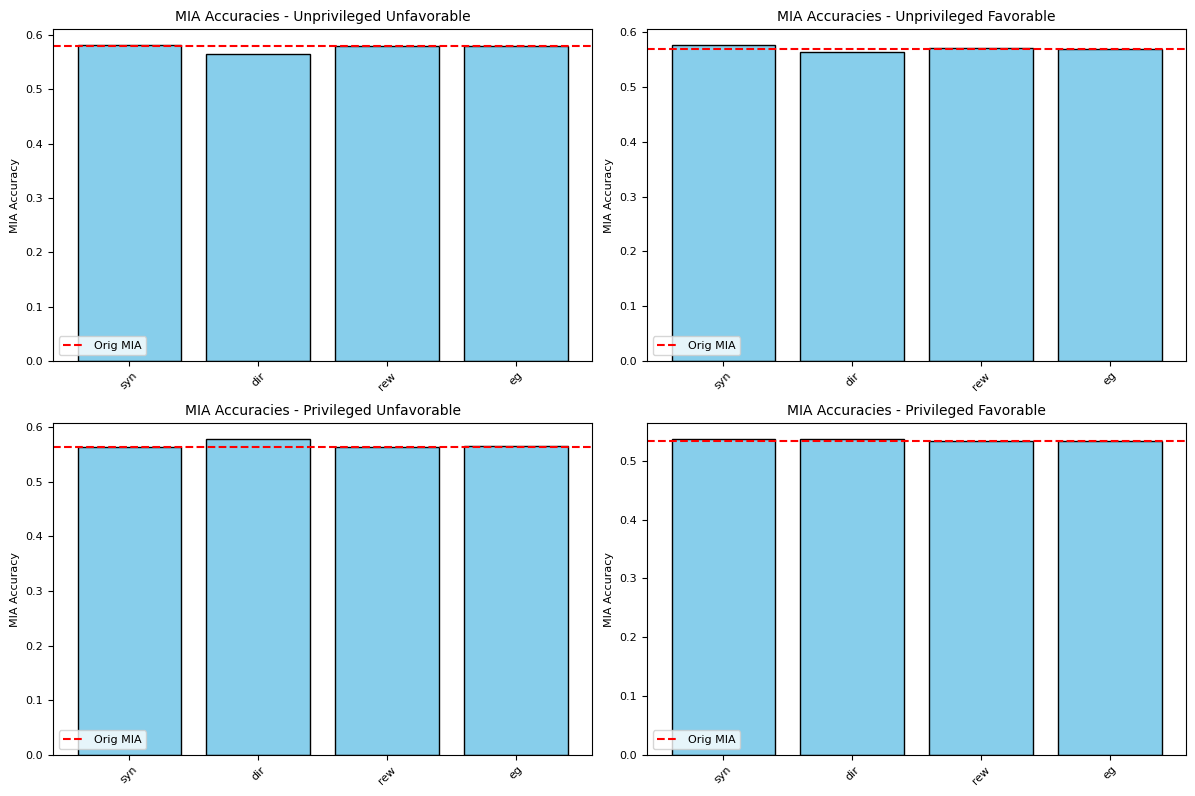

In [64]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [65]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [66]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [67]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.512500
1,orig,entire_dataset_mia_privacy_risk,0.512500
2,orig,entire_dataset_mia_privacy_risk,0.525000
3,orig,entire_dataset_mia_privacy_risk,0.508333
4,orig,entire_dataset_mia_privacy_risk,0.550000
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.576389
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.500000
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.489293
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.568910


In [68]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.512500
1,orig,entire_dataset_mia_privacy_risk,0.512500
2,orig,entire_dataset_mia_privacy_risk,0.525000
3,orig,entire_dataset_mia_privacy_risk,0.508333
4,orig,entire_dataset_mia_privacy_risk,0.550000
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.576389
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.500000
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.489293
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.568910


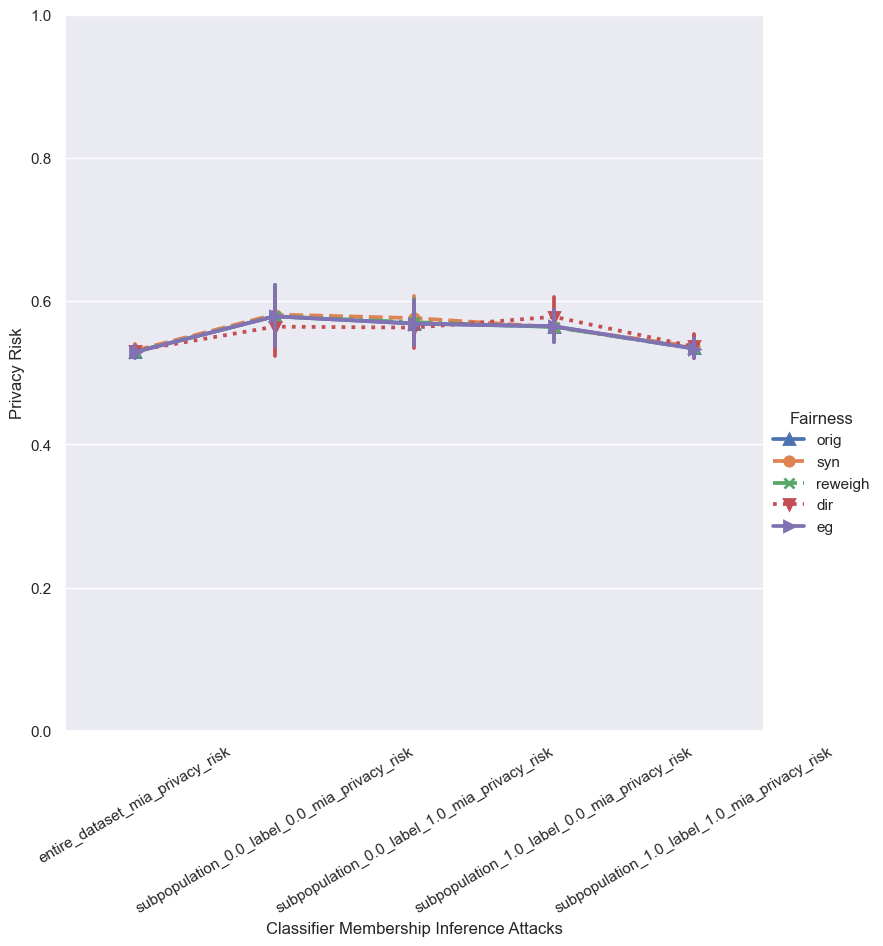

In [69]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [70]:
from sklearn.metrics import RocCurveDisplay, auc

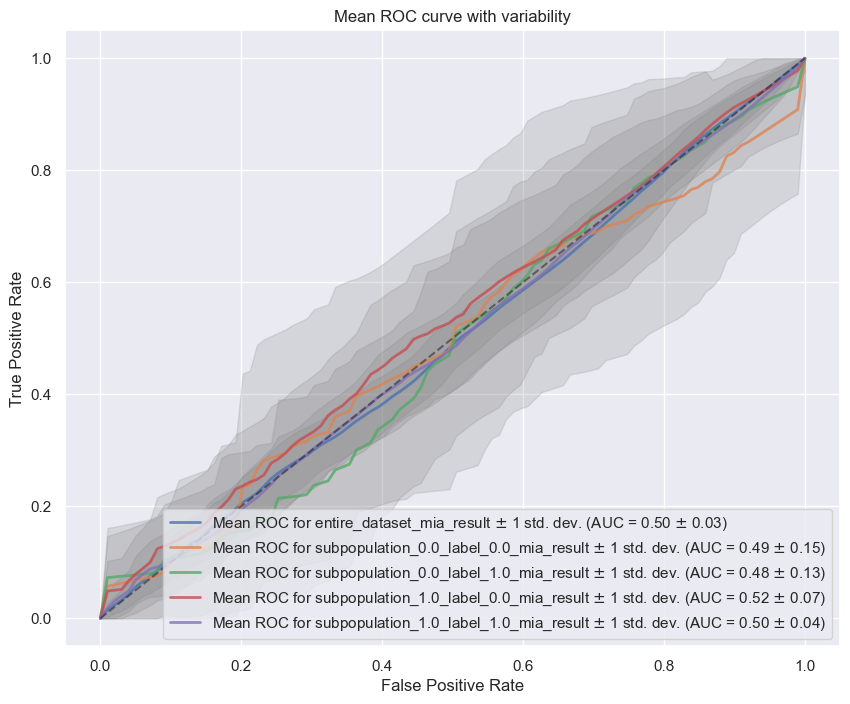

In [71]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.07
  Positive predictive value: 0.51
  Optimal thershold: [0.94042348]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.46
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.12
  Positive predictive value: 1.00
  Optimal thershold: [0.51510747]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.50
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.05
  Positive predictive value: 0.75
  Optimal thershold: [0.5144344]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 120, Test = 120
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Acc

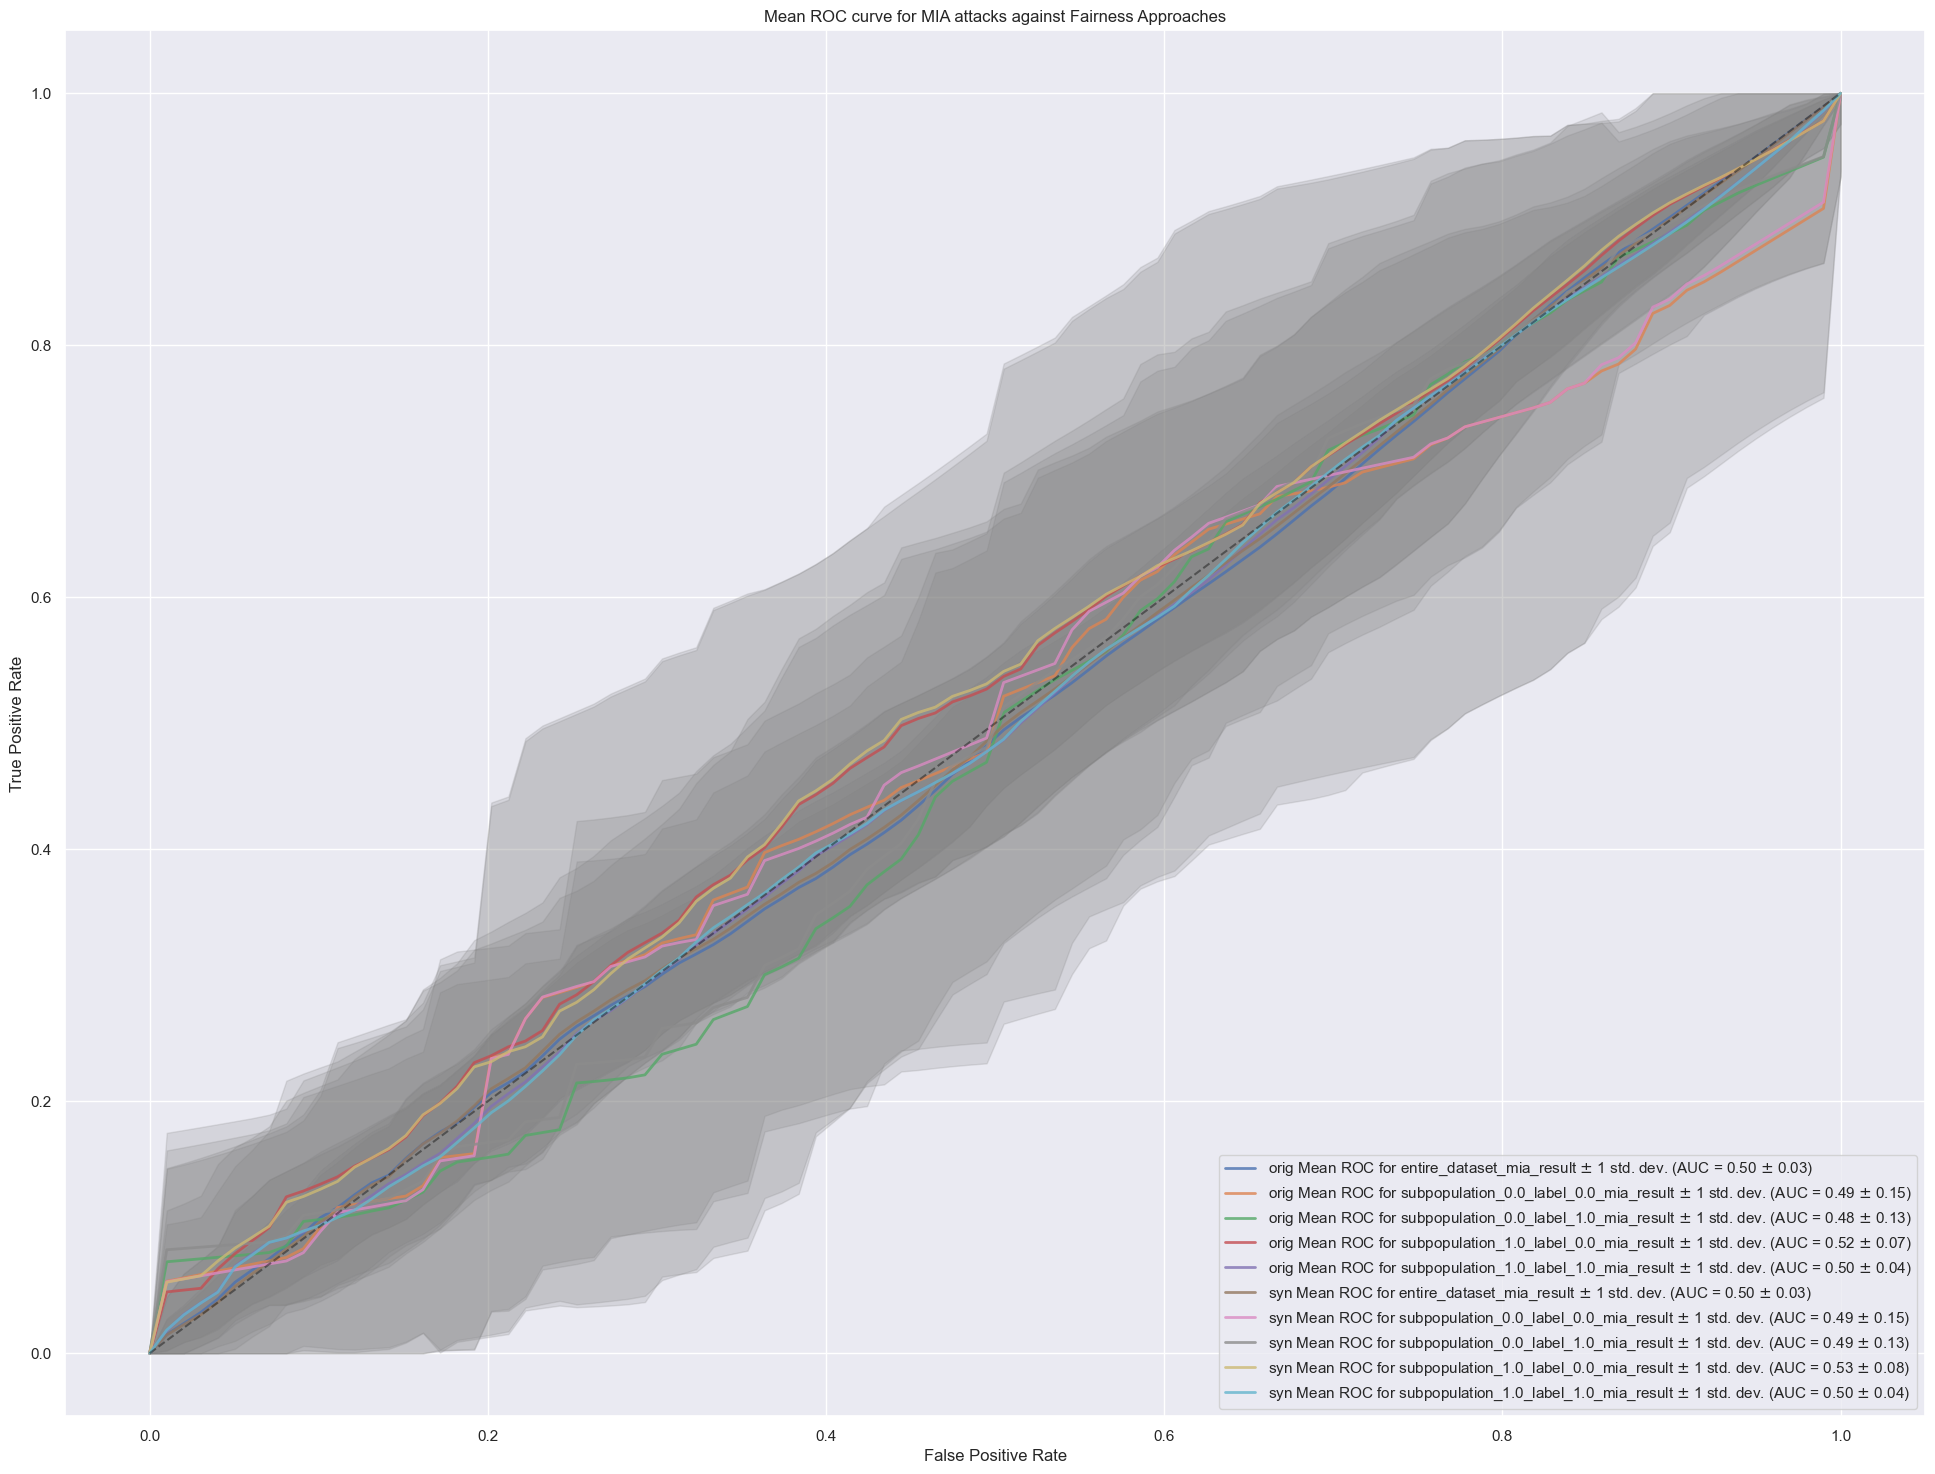

In [72]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

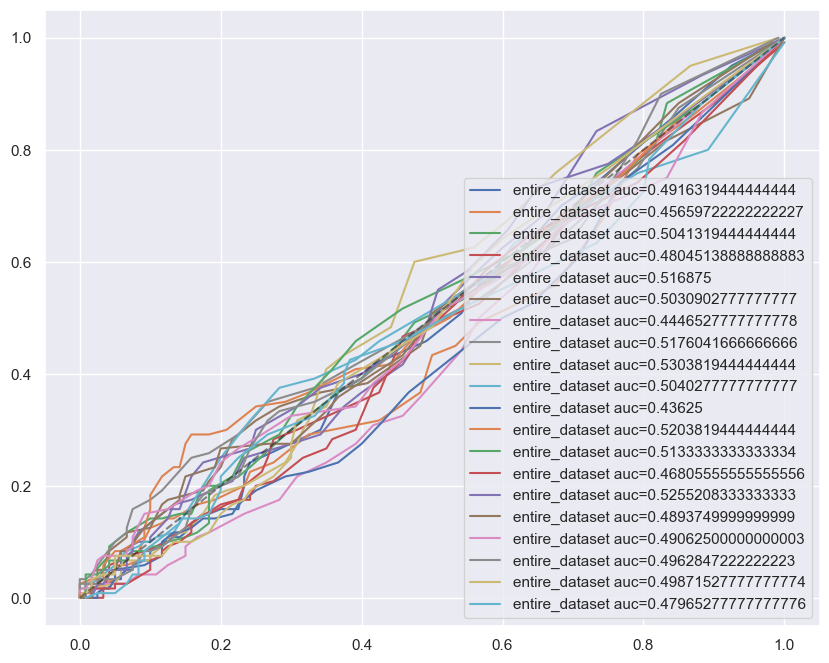

In [73]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [74]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [75]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,
orig,0.493382,0.447446,0.447092,0.508969,0.493211
syn,0.495408,0.448789,0.454927,0.513193,0.492934
dir,0.495391,0.445372,0.445024,0.525450,0.501038
rew,0.493464,0.450971,0.445977,0.510590,0.493144
egr,0.493613,0.450153,0.445955,0.514069,0.493774


<Axes: xlabel='Classifier MIA Attacks'>

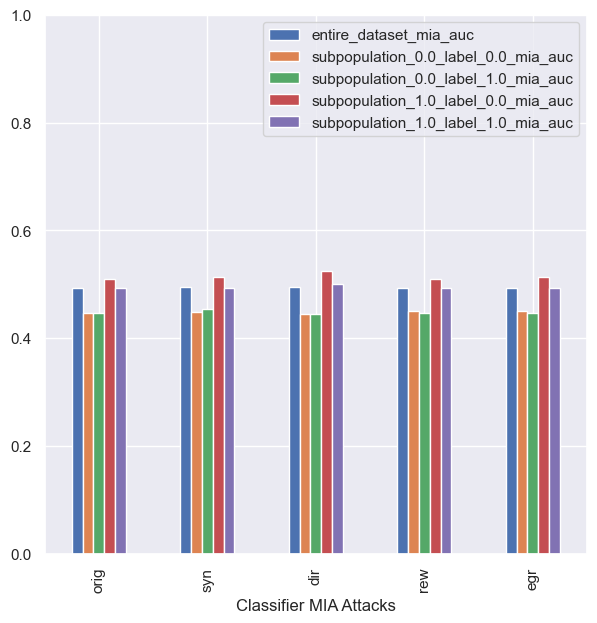

In [76]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [77]:
# Creating data structures to plot point categorical plot from seaborn

In [78]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [79]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.06666666666666668],
 ['orig', 'entire_dataset', 0.1166666666666667],
 ['orig', 'entire_dataset', 0.05],
 ['orig', 'entire_dataset', 0.05833333333333335],
 ['orig', 'entire_dataset', 0.10000000000000009],
 ['orig', 'entire_dataset', 0.06666666666666665],
 ['orig', 'entire_dataset', 0.1333333333333333],
 ['orig', 'entire_dataset', 0.09166666666666667],
 ['orig', 'entire_dataset', 0.125],
 ['orig', 'entire_dataset', 0.09166666666666667],
 ['orig', 'entire_dataset', 0.125],
 ['orig', 'entire_dataset', 0.13333333333333336],
 ['orig', 'entire_dataset', 0.06666666666666665],
 ['orig', 'entire_dataset', 0.09166666666666667],
 ['orig', 'entire_dataset', 0.08333333333333326],
 ['orig', 'entire_dataset', 0.06666666666666668],
 ['orig', 'entire_dataset', 0.08333333333333337],
 ['orig', 'entire_dataset', 0.07500000000000007],
 ['orig', 'entire_dataset', 0.06666666666666665],
 ['orig', 'entire_dataset', 0.09999999999999998],
 ['orig', 'subpopulation_0.0_label_0.0', 0.59

In [80]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.066667
1,orig,entire_dataset,0.116667
2,orig,entire_dataset,0.050000
3,orig,entire_dataset,0.058333
4,orig,entire_dataset,0.100000
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.152778
496,egr,subpopulation_1.0_label_1.0,0.118096
497,egr,subpopulation_1.0_label_1.0,0.132640
498,egr,subpopulation_1.0_label_1.0,0.137821


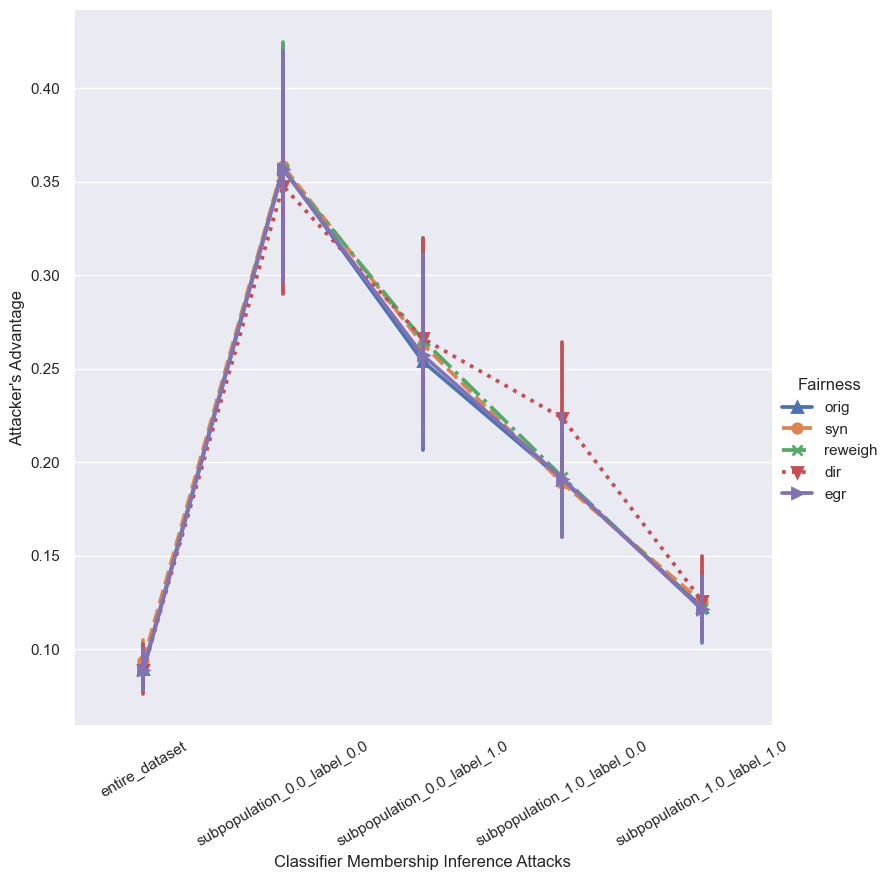

In [81]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


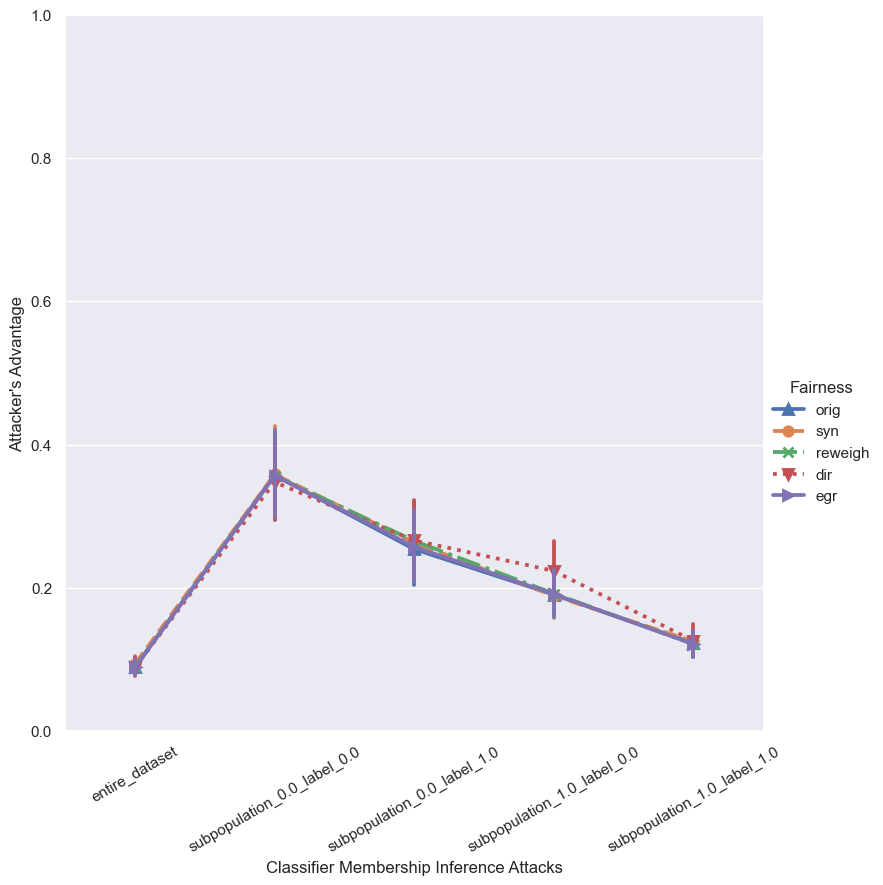

In [82]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [83]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.066667,0.596154,0.384615,0.137931,0.091355
1,0.116667,0.514286,0.375000,0.160839,0.100218
2,0.050000,0.371429,0.138889,0.314381,0.072464
3,0.058333,0.707071,0.190045,0.209957,0.093333
4,0.100000,0.163636,0.116667,0.191919,0.167963
5,0.066667,0.230769,0.140271,0.200000,0.124506
6,0.133333,0.363636,0.252747,0.149275,0.058442
7,0.091667,0.166667,0.285714,0.245614,0.128343
8,0.125000,0.267677,0.500000,0.074074,0.135931
9,0.091667,0.233333,0.272727,0.158103,0.163580


In [84]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [85]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,
orig,0.089583,0.357309,0.253981,0.190512,0.122539
syn,0.093750,0.358342,0.263219,0.188840,0.125246
dir,0.088750,0.347686,0.266157,0.223657,0.125930
rew,0.089167,0.356594,0.265528,0.192074,0.121308
egr,0.088750,0.356594,0.257267,0.191161,0.121395


<Axes: xlabel='Classifier MIA Attacks'>

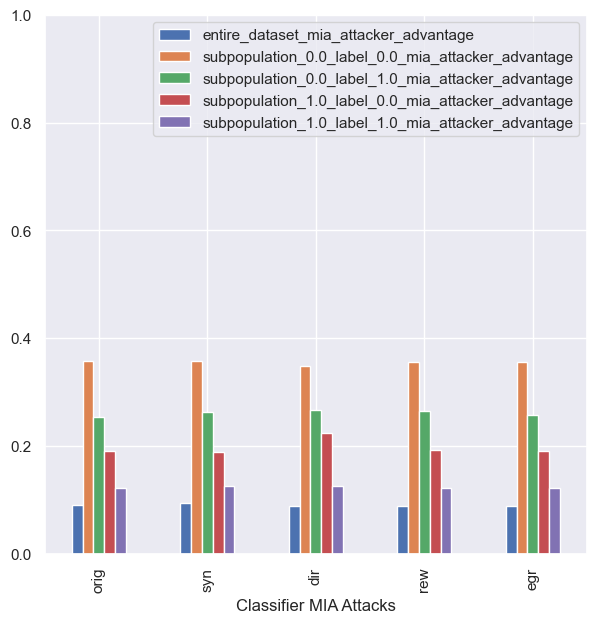

In [86]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [87]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [88]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5066666666666666],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.75],
 ['orig', 'entire_dataset', 0.5833333333333333],
 ['orig', 'entire_dataset', 0.6],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.5],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.8333333333333334],
 ['orig', 'entire_dataset', 0.5035971223021584],
 ['orig', 'entire_dataset', 0.5833333333333333],
 ['orig', 'entire_dataset', 0.6],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.6666666666666666],
 ['orig', 'entire_dataset', 0.5263157894736842],
 ['orig', 'subpopulation_0.0_label_0.0', 0.52],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7142857142857143],
 ['orig', 'subpopulation_0.0_label_0.0', 1.0],
 ['orig', 'subpopulation_0.0_label_0.0', 0.44999999999999

In [89]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.506667
1,orig,entire_dataset,1.000000
2,orig,entire_dataset,0.750000
3,orig,entire_dataset,0.583333
4,orig,entire_dataset,0.600000
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.700000
496,egr,subpopulation_1.0_label_1.0,0.482517
497,egr,subpopulation_1.0_label_1.0,0.483051
498,egr,subpopulation_1.0_label_1.0,1.000000


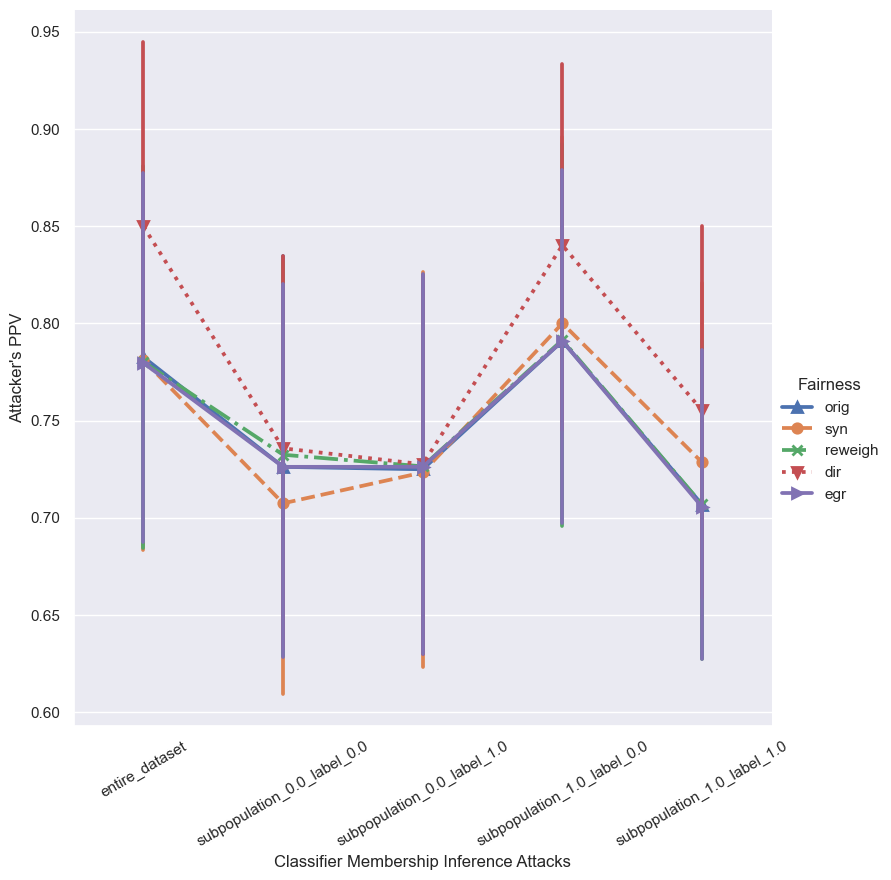

In [90]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
